eps = 100
batch_size = 32
learning_rate = 0.001

In [1]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the Fashion MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize the image intensity to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add a channel dimension (rank-4 shape) for compatibility with Conv2D layers
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Split the training data into train and validation sets
x_train, x_val = train_test_split(x_train, random_state=42, test_size=0.2)

4422102/4422102 [==============================] - 1s 0us/step


In [2]:
# Define Gaussian Noise Function
def add_gaussian_noise(img, mean=0, std=1, noise_factor=0.5):
    noise = np.random.normal(mean, std, img.shape)
    noisy_img = img + noise_factor * noise
    noisy_img = np.clip(noisy_img, 0, 1)  # Ensure pixel values are in [0, 1] range
    return noisy_img

def create_autoencoder_model(optimizer, learning_rate):
    input_img = Input(shape=(28, 28, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy')

    return autoencoder

In [4]:
# Set hyperparameters
eps = 100
batch_size = 32
learning_rate = 0.001

# Create an instance of the data generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=add_gaussian_noise
)

# Create the autoencoder model
autoencoder = create_autoencoder_model(optimizer=Adam, learning_rate=learning_rate)

# Define an Early Stopping callback
callback = EarlyStopping(monitor='loss', patience=10)

# Train the autoencoder using fit_generator
history = autoencoder.fit_generator(
    datagen.flow(x_train, x_train, batch_size=batch_size),
    epochs=eps,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=datagen.flow(x_val, x_val, batch_size=batch_size),
    callbacks=[callback],
    verbose=1
)

C:\Users\Acer Aspire 7\AppData\Local\Temp\ipykernel_18520\829475349.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(


Epoch 1/100
1500/1500 [==============================] - 37s 18ms/step - loss: 0.3948 - val_loss: 0.3776
Epoch 2/100
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3721 - val_loss: 0.3675
Epoch 3/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3651 - val_loss: 0.3638
Epoch 4/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3616 - val_loss: 0.3596
Epoch 5/100
1500/1500 [==============================] - 20s 14ms/step - loss: 0.3597 - val_loss: 0.3584
Epoch 6/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3585 - val_loss: 0.3582
Epoch 7/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3576 - val_loss: 0.3560
Epoch 8/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3566 - val_loss: 0.3571
Epoch 9/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3557 - val_loss: 0.3552
Epoch 10/100
1500/1500 [==============================]

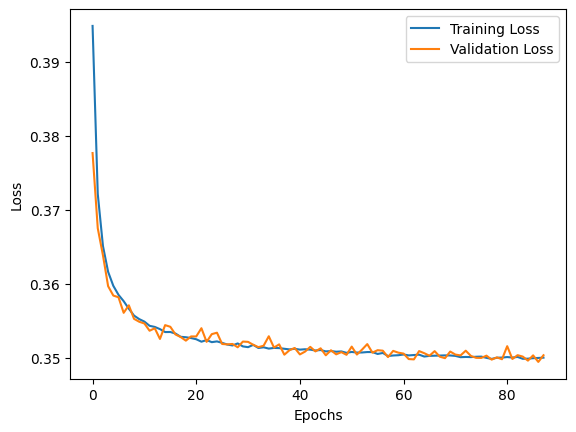

313/313 [==============================] - 3s 8ms/step


In [5]:
# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate noisy test data
x_test_noisy = np.array([add_gaussian_noise(img) for img in x_test])

# Make predictions using the trained autoencoder
predict_test = autoencoder.predict(x_test_noisy)


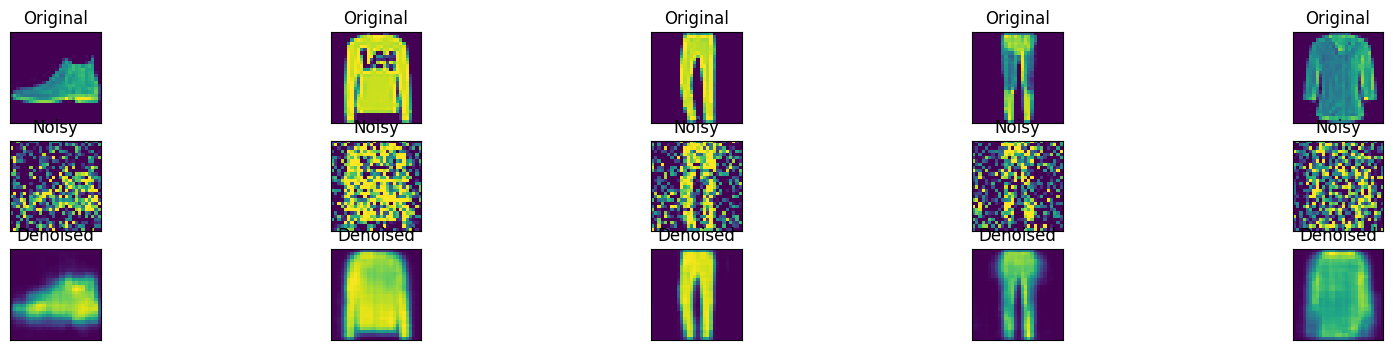

In [6]:
#Visualize original, noisy, and denoised images
n = 5 

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised image
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(predict_test[i].reshape(28, 28))
    plt.title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

eps = 40
batch_size = 16
learning_rate = 0.01

In [7]:
#Define Gaussian Noise Function
def add_gaussian_noise(img, mean=0, std=0.6, noise_factor=0.3):
    noise = np.random.normal(mean, std, img.shape)
    noisy_img = img + noise_factor * noise
    noisy_img = np.clip(noisy_img, 0, 1)
    return noisy_img

In [8]:
def create_model(optimizer, learning_rate):
    # Encoder
    input_img = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer(learning_rate=learning_rate), loss='mean_squared_error')
    return autoencoder

In [9]:
eps = 40
batch_size = 16
learning_rate = 0.01


# Create the autoencoder model
autoencoder = create_model(optimizer=Adam, learning_rate=learning_rate)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    preprocessing_function=add_gaussian_noise
)

callback = EarlyStopping(monitor='loss', patience=10)
history = autoencoder.fit_generator(
    datagen.flow(x_train, x_train, batch_size=batch_size),
    epochs=eps,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=datagen.flow(x_val, x_val, batch_size=batch_size),
    callbacks=[callback],
    verbose=1
)

Epoch 1/20


C:\Users\Acer Aspire 7\AppData\Local\Temp\ipykernel_18520\474874214.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(


3000/3000 [==============================] - 51s 16ms/step - loss: 0.0562 - val_loss: 0.0553
Epoch 2/20
3000/3000 [==============================] - 30s 10ms/step - loss: 0.0547 - val_loss: 0.0542
Epoch 3/20
3000/3000 [==============================] - 28s 9ms/step - loss: 0.0543 - val_loss: 0.0542
Epoch 4/20
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0542 - val_loss: 0.0536
Epoch 5/20
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0538 - val_loss: 0.0533
Epoch 6/20
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0539 - val_loss: 0.0540
Epoch 7/20
3000/3000 [==============================] - 31s 10ms/step - loss: 0.0537 - val_loss: 0.0528
Epoch 8/20
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0538 - val_loss: 0.0542
Epoch 9/20
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0537 - val_loss: 0.0543
Epoch 10/20
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0

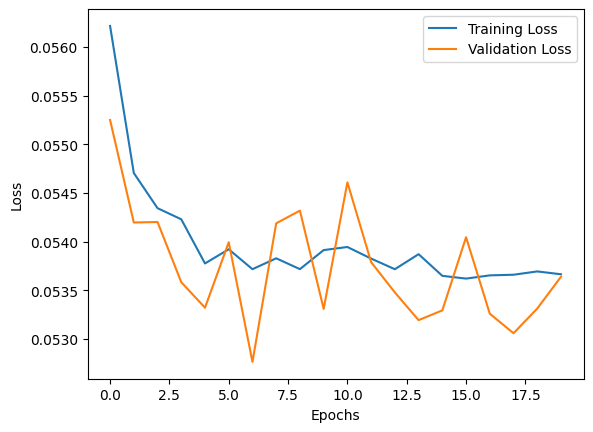

313/313 [==============================] - 1s 4ms/step


In [10]:
# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate noisy test data
x_test_noisy = np.array([add_gaussian_noise(img) for img in x_test])

# Make predictions using the trained autoencoder
predict_test = autoencoder.predict(x_test_noisy)


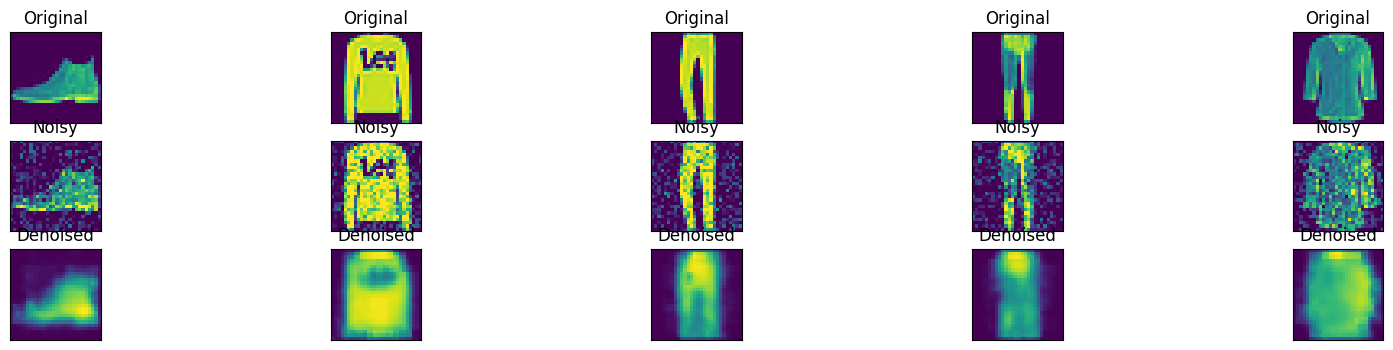

In [11]:
# Visualize original, noisy, and denoised images
n = 5  # Number of examples to visualize

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised image
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(predict_test[i].reshape(28, 28))
    plt.title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()